In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scipy.stats import multivariate_normal as sp_mvnorm
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
from tqdm import tqdm
import pandas as pd
import datetime

import pickle
import jax
import cvxpy as cvx

In [5]:
from aaai_helpers.optim import *
from aaai_helpers.eval import *
from aaai_helpers.jax_spm import *
from aaai_helpers.baselines import *
from aaai_helpers.plots import *
from aaai_helpers.utils import *

Download data at http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

In [5]:
df_cu2 = pd.read_csv('criteo-research-uplift-v2.1.csv.gz')

preprocessing

In [6]:
def df_prepro_cu2_2d(df, policies_col, v_col, c_col, partition_col, groups, n_bs):
    if type(groups) == int:
        df['groups'] = pd.qcut(df[partition_col], groups, labels=False, duplicates='drop')
    elif type(groups) == list:
        df['groups'] = pd.cut(df[partition_col], bins=groups, labels=False, include_lowest=1)
    
    df_grouped = df[[policies_col,v_col,c_col,'groups']].groupby(['groups', policies_col]).apply(lambda x: agg_sum_and_bs_sum2(x, [v_col,c_col], n_bs)).reset_index()
    print(df_grouped.columns)
    
    return df_grouped


def agg_sum_and_bs_sum2(group_df, colnames, n_bs=30, random_state=23409834):
    '''
    Aggregation function that performs summation of original values along with summations of the bootstraps (by sampling with replacements).
    '''
    bootstrap_pops = np.random.choice(len(group_df), size=(len(group_df), n_bs), replace=True)
    col_sums = {}

    for colname in colnames:
        vals = group_df[colname].values
        bs_sums = np.sum(vals[bootstrap_pops], axis=0)
        col_sums[colname+"_bs"] = bs_sums
        
    simple_sums = group_df[colnames].sum()
    col_sums.update(simple_sums)

    return pd.Series(col_sums)

In [7]:
df_cu2 = df_cu2.sample(frac=1, random_state=293294)
ind_train = int(len(df_cu2)/2.)

n_t = np.sum(df_cu2.treatment==1)
n_c = np.sum(df_cu2.treatment==0)
mean_t = np.mean(df_cu2.treatment==1)
mean_c = np.mean(df_cu2.treatment==0)

In [8]:
params_cu2 = {
    'policies_col': 'treatment',
    'c_col': 'visit',
    'v_col': 'conversion',
    'partition_col': 'f0',
    'nb_groups_theo': 10,
    'n_bs': 100,
}

In [9]:
np.random.seed(797689)

df_cu2_grouped_train = df_prepro_cu2_2d(df_cu2[:ind_train], params_cu2['policies_col'], params_cu2['v_col'], params_cu2['c_col'], params_cu2['partition_col'], params_cu2['nb_groups_theo'], params_cu2['n_bs'])
_, bins_train = pd.qcut(df_cu2[:ind_train][params_cu2['partition_col']], params_cu2['nb_groups_theo'], retbins=True, labels=False, duplicates='drop')
df_cu2_grouped_test = df_prepro_cu2_2d(df_cu2[ind_train:], params_cu2['policies_col'], params_cu2['v_col'], params_cu2['c_col'], params_cu2['partition_col'], list(bins_train), params_cu2['n_bs'])

df_cu2_grouped_train[params_cu2['v_col']+'_bs'] = df_cu2_grouped_train.apply(
    lambda x: x[params_cu2['v_col']+'_bs'] / mean_t if x[params_cu2['policies_col']]==1 else x[params_cu2['v_col']+'_bs'] / mean_c, 
    axis=1
)
df_cu2_grouped_train[params_cu2['c_col']+'_bs'] = df_cu2_grouped_train.apply(
    lambda x: x[params_cu2['c_col']+'_bs'] / mean_t if x[params_cu2['policies_col']]==1 else x[params_cu2['c_col']+'_bs'] / mean_c, 
    axis=1
)
df_cu2_grouped_test[params_cu2['v_col']+'_bs'] = df_cu2_grouped_test.apply(
    lambda x: x[params_cu2['v_col']+'_bs'] / mean_t if x[params_cu2['policies_col']]==1 else x[params_cu2['v_col']+'_bs'] / mean_c, 
    axis=1
)
df_cu2_grouped_test[params_cu2['c_col']+'_bs'] = df_cu2_grouped_test.apply(
    lambda x: x[params_cu2['c_col']+'_bs'] / mean_t if x[params_cu2['policies_col']]==1 else x[params_cu2['c_col']+'_bs'] / mean_c, 
    axis=1
)

df_cu2_grouped_train['v_c_bs_cov'] = df_cu2_grouped_train.apply(lambda x: np.cov(np.stack((x[params_cu2['v_col']+'_bs'], x[params_cu2['c_col']+'_bs']))).flatten(), axis=1)
df_cu2_grouped_test['v_c_bs_cov'] = df_cu2_grouped_test.apply(lambda x: np.cov(np.stack((x[params_cu2['v_col']+'_bs'], x[params_cu2['c_col']+'_bs']))).flatten(), axis=1)

df_cu2_grouped_train[params_cu2['v_col']+'_bs_mean'] = df_cu2_grouped_train[params_cu2['v_col']+'_bs'].apply(lambda x:np.mean(x))
df_cu2_grouped_train[params_cu2['c_col']+'_bs_mean'] = df_cu2_grouped_train[params_cu2['c_col']+'_bs'].apply(lambda x:np.mean(x))
df_cu2_grouped_test[params_cu2['c_col']+'_bs_mean'] = df_cu2_grouped_test[params_cu2['c_col']+'_bs'].apply(lambda x:np.mean(x))
df_cu2_grouped_test[params_cu2['v_col']+'_bs_mean'] = df_cu2_grouped_test[params_cu2['v_col']+'_bs'].apply(lambda x:np.mean(x))

mu_0_v_cu2_train = df_cu2_grouped_train.pivot(index='groups', columns=params_cu2['policies_col'], values=[params_cu2['v_col']+'_bs_mean']).values
mu_0_c_cu2_train = df_cu2_grouped_train.pivot(index='groups', columns=params_cu2['policies_col'], values=[params_cu2['c_col']+'_bs_mean']).values
mu_0_cu2_train = np.stack((mu_0_v_cu2_train, mu_0_c_cu2_train), axis=2)
cov_0_cu2_train = df_cu2_grouped_train.pivot(index='groups', columns=params_cu2['policies_col'], values=['v_c_bs_cov']).values
cov_0_cu2_train = np.array(cov_0_cu2_train.tolist())

mu_0_v_cu2_test = df_cu2_grouped_test.pivot(index='groups', columns=params_cu2['policies_col'], values=[params_cu2['v_col']+'_bs_mean']).values
mu_0_c_cu2_test = df_cu2_grouped_test.pivot(index='groups', columns=params_cu2['policies_col'], values=[params_cu2['c_col']+'_bs_mean']).values
mu_0_cu2_test = np.stack((mu_0_v_cu2_test, mu_0_c_cu2_test), axis=2)
cov_0_cu2_test = df_cu2_grouped_test.pivot(index='groups', columns=params_cu2['policies_col'], values=['v_c_bs_cov']).values
cov_0_cu2_test = np.array(cov_0_cu2_test.tolist())

df_cu2_nbucket, df_cu2_npol = mu_0_v_cu2_train.shape

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['groups', 'treatment', 'conversion_bs', 'visit_bs', 'conversion',
       'visit'],
      dtype='object')


/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Index(['groups', 'treatment', 'conversion_bs', 'visit_bs', 'conversion',
       'visit'],
      dtype='object')


In [14]:
# with open('cu2_data_2d_f0_8buckets.pickle', 'wb') as f:
#     pickle.dump({'train': {'mu': mu_0_cu2_train, 'cov': cov_0_cu2_train}, 'test': {'mu': mu_0_cu2_test, 'cov': cov_0_cu2_test}}, f)

or open preprocced data from Pickle

In [8]:
# with open('cu2_data_2d_f0_8buckets.pickle', 'rb') as f:
#     cu2_data = pickle.load(f)

# mu_0_cu2_train = cu2_data['train']['mu']
# cov_0_cu2_train = cu2_data['train']['cov']

# mu_0_cu2_test = cu2_data['test']['mu']
# cov_0_cu2_test = cu2_data['test']['cov']

# mu_0_v_cu2_train = mu_0_cu2_train[:,:,0]
# mu_0_c_cu2_train = mu_0_cu2_train[:,:,-1]

# mu_0_v_cu2_test = mu_0_cu2_test[:,:,0]
# mu_0_c_cu2_test = mu_0_cu2_test[:,:,-1]

# df_cu2_nbucket, df_cu2_npol = mu_0_v_cu2_train.shape

In [9]:
ref_col_cu2 = 0

total_v_ref_cu2_train = np.sum(np.array(mu_0_v_cu2_train)[:,ref_col_cu2])
total_c_ref_cu2_train = np.sum(np.array(mu_0_c_cu2_train)[:,ref_col_cu2])

total_v_ref_cu2_test = np.sum(np.array(mu_0_v_cu2_test)[:,ref_col_cu2])
total_c_ref_cu2_test = np.sum(np.array(mu_0_c_cu2_test)[:,ref_col_cu2])

In [10]:
r_v_pct_cu2_range = np.arange(0, 0.21, 0.01)
r_c_pct_cu2_range = np.arange(0, 0.21, 0.01)

R_vs_cu2_train = total_v_ref_cu2_train * (1 + r_v_pct_cu2_range)
R_cs_cu2_train = total_c_ref_cu2_train * (1 + r_c_pct_cu2_range)
R_vs_cu2_test = total_v_ref_cu2_test * (1 + r_v_pct_cu2_range)
R_cs_cu2_test = total_c_ref_cu2_test * (1 + r_c_pct_cu2_range)

methods = ['Bruteforce', 'LinProg', 'MixedInt', 'SuccessProbaMax']
res_2d_train = {i:np.zeros((R_vs_cu2_train.shape[0],R_cs_cu2_train.shape[0])) for i in methods}
res_2d_test = {i:np.zeros((R_vs_cu2_train.shape[0],R_cs_cu2_train.shape[0])) for i in methods}

In [11]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=df_cu2_npol)) if sum(comb) == 1]
cu2_all_hard_allocs = np.array(list(itertools.product(candidates, repeat=df_cu2_nbucket)))

### psi_0s for SuccessProbaMax
cu2_psi_0s = jnp.array([random.dirichlet(random.PRNGKey(i*23563), np.ones(df_cu2_npol), shape=(df_cu2_nbucket,)) for i in range(50000)])

In [12]:
for v in tqdm(range(len(R_vs_cu2_train))):
    for c in range(len(R_cs_cu2_train)):
        hard_bf_alloc = hard_bruteforce_2d_v2(cu2_all_hard_allocs, mu_0_cu2_train, cov_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c])
        res_2d_train['Bruteforce'][v][c] = evaluate_2d_v2(hard_bf_alloc, mu_0_cu2_train, cov_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c])
        res_2d_test['Bruteforce'][v][c] = evaluate_2d_v2(hard_bf_alloc, mu_0_cu2_test, cov_0_cu2_test, R_vs_cu2_test[v], R_cs_cu2_test[c])

        greedy_soft_alloc = greedy_2d(mu_0_v_cu2_train, mu_0_c_cu2_train, R_cs_cu2_train[c], df_cu2_nbucket, df_cu2_npol)
        res_2d_train['LinProg'][v,c] = evaluate_2d_v2(greedy_soft_alloc, mu_0_cu2_train, cov_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c])
        # print(v,c,res_2d_train['LinProg'][v,c])
        res_2d_test['LinProg'][v,c] = evaluate_2d_v2(greedy_soft_alloc, mu_0_cu2_test, cov_0_cu2_test, R_vs_cu2_test[v], R_cs_cu2_test[c])

        greedy_mi_alloc = greedy_2d(mu_0_v_cu2_train, mu_0_c_cu2_train, R_cs_cu2_train[c], df_cu2_nbucket, df_cu2_npol, soft=0)
        res_2d_train['MixedInt'][v,c] = evaluate_2d_v2(greedy_mi_alloc, mu_0_cu2_train, cov_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c])
        res_2d_test['MixedInt'][v,c] = evaluate_2d_v2(greedy_mi_alloc, mu_0_cu2_test, cov_0_cu2_test, R_vs_cu2_test[v], R_cs_cu2_test[c])

        spm_alloc = optimize_2d_my_v4(cov_0_cu2_train, mu_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c], cu2_psi_0s, n_steps=1000000, eta = 0.001)
        res_2d_train['SuccessProbaMax'][v][c] = evaluate_2d_v2(spm_alloc, mu_0_cu2_train, cov_0_cu2_train, R_vs_cu2_train[v], R_cs_cu2_train[c])
        res_2d_test['SuccessProbaMax'][v][c] = evaluate_2d_v2(spm_alloc, mu_0_cu2_test, cov_0_cu2_test, R_vs_cu2_test[v], R_cs_cu2_test[c])

  5%|▍         | 1/21 [01:58<39:23, 118.17s/it]


KeyboardInterrupt: 

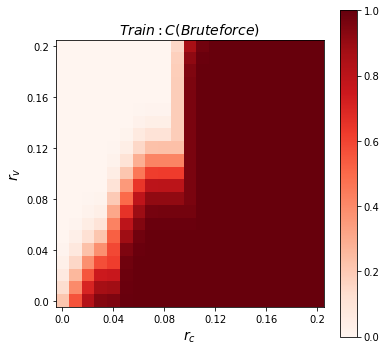

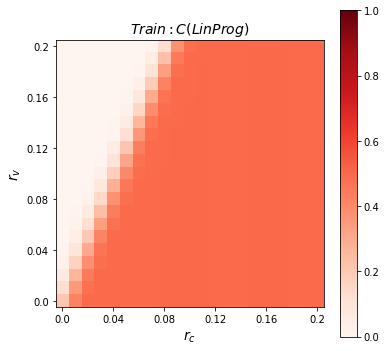

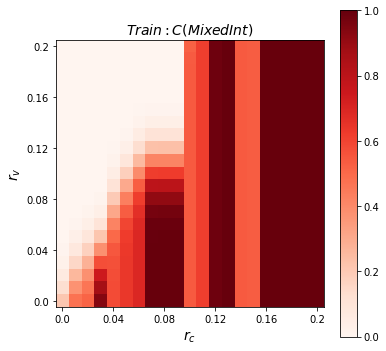

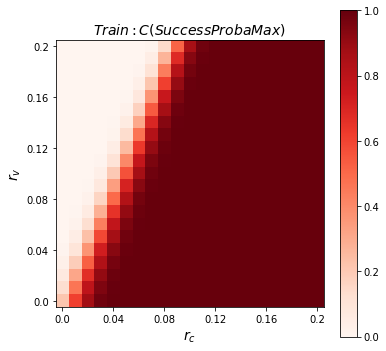

In [25]:
for m in methods[:]:
    plt.figure(figsize=(6,6))
    fontsize = 14

    plt.imshow(res_2d_train[m][::-1, :], cmap='Reds', vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('$r_c$', fontsize=fontsize)
    plt.ylabel('$r_v$', fontsize=fontsize)
    plt.title('$Train: C('+m+')$', fontsize=fontsize)
    plt.xticks(np.arange(len(R_cs_cu2_train), step=4), r_c_pct_cu2_range[::4])
    plt.yticks(np.arange(len(R_cs_cu2_train), step=4), r_v_pct_cu2_range[::-1][::4])
    plt.show()

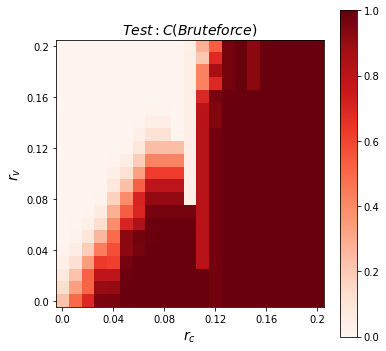

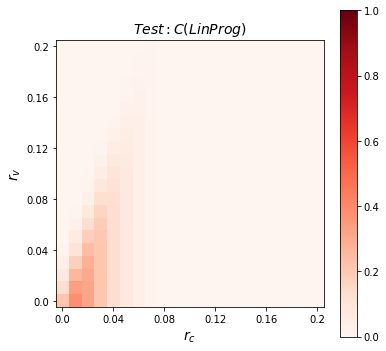

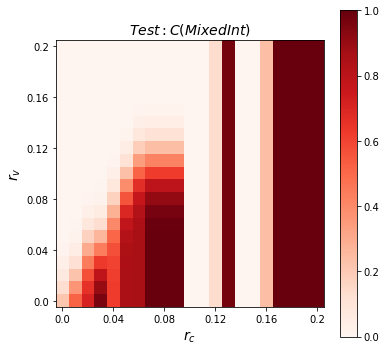

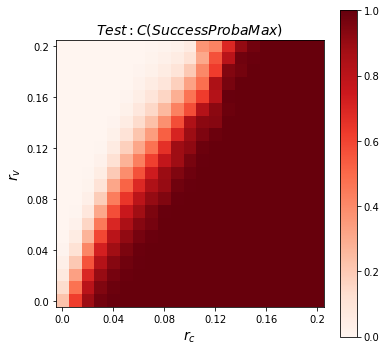

In [26]:
for m in methods[:]:
    plt.figure(figsize=(6,6))
    fontsize = 14

    plt.imshow(res_2d_test[m][::-1, :], cmap='Reds', vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('$r_c$', fontsize=fontsize)
    plt.ylabel('$r_v$', fontsize=fontsize)
    plt.title('$Test: C('+m+')$', fontsize=fontsize)
    plt.xticks(np.arange(len(R_cs_cu2_train), step=4), r_c_pct_cu2_range[::4])
    plt.yticks(np.arange(len(R_cs_cu2_train), step=4), r_v_pct_cu2_range[::-1][::4])
    plt.show()

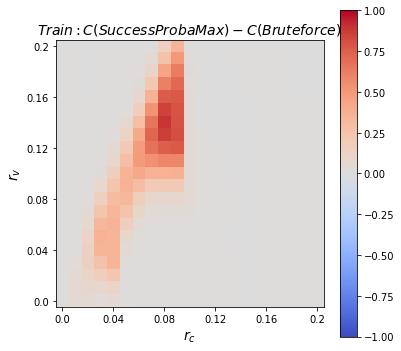

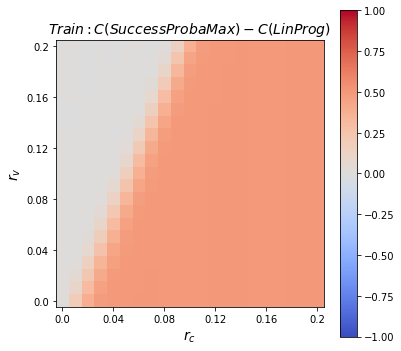

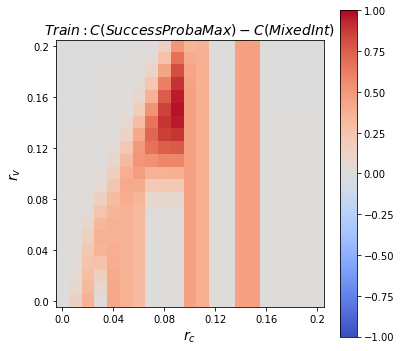

In [23]:
for m in methods[:-1]:
    plt.figure(figsize=(6,6))
    fontsize = 14

    plt.imshow(res_2d_train['SuccessProbaMax'][::-1, :] - res_2d_train[m][::-1, :], cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xlabel('$r_c$', fontsize=fontsize)
    plt.ylabel('$r_v$', fontsize=fontsize)
    plt.title('$Train: C(SuccessProbaMax) - C('+m+')$', fontsize=fontsize)
    plt.xticks(np.arange(len(R_cs_cu2_train), step=4), r_c_pct_cu2_range[::4])
    plt.yticks(np.arange(len(R_cs_cu2_train), step=4), r_v_pct_cu2_range[::-1][::4])
    plt.show()

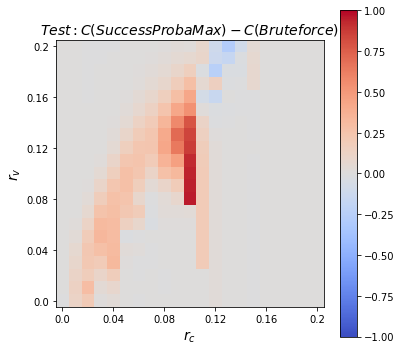

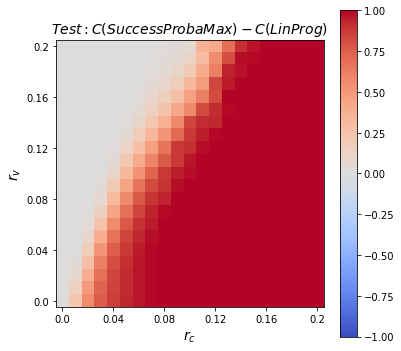

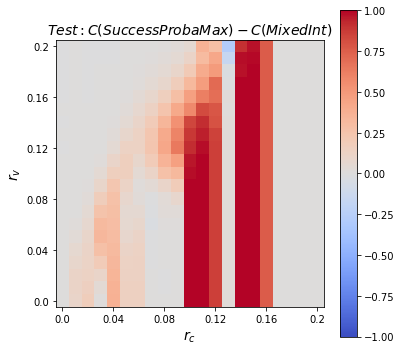

In [24]:
for m in methods[:-1]:
    plt.figure(figsize=(6,6))
    fontsize = 14

    plt.imshow(res_2d_test['SuccessProbaMax'][::-1, :] - res_2d_test[m][::-1, :], cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xlabel('$r_c$', fontsize=fontsize)
    plt.ylabel('$r_v$', fontsize=fontsize)
    plt.title('$Test: C(SuccessProbaMax) - C('+m+')$', fontsize=fontsize)
    plt.xticks(np.arange(len(R_cs_cu2_train), step=4), r_c_pct_cu2_range[::4])
    plt.yticks(np.arange(len(R_cs_cu2_train), step=4), r_v_pct_cu2_range[::-1][::4])
    plt.show()

In [465]:
def df_prepro_h(df, policies_col, y_col, partition_col, groups, n_bs):
    if type(groups) == int:
        df['groups'] = pd.qcut(df[partition_col], groups, labels=False, duplicates='drop')
    elif type(groups) == list:
        df['groups'] = pd.cut(df[partition_col], bins=groups, labels=False, include_lowest=1)#.astype(int)
    
    df_grouped = df[[policies_col,y_col,'groups']].groupby(['groups', policies_col]).apply(lambda x: agg_sum_and_bs_sum2(x, [y_col], n_bs)).reset_index()
    print(df_grouped.columns)
    
    # counts = df[['treatment','groups']].groupby(['groups', 'treatment']).size().reset_index(name='counts')
    # df_grouped[y_col+'_w'] = df_grouped[y_col] / (counts_train.counts / len(cu2_df))
    # df_grouped[y_col+'_bs_w'] = df_grouped[y_col+'_bs'] / (counts_train.counts / len(cu2_df))
    
    return df_grouped


def agg_sum_and_bs_sum2(group_df, colnames, n_bs=30, random_state=23409834):
    '''
    Aggregation function that performs summation of original values along with summations of the bootstraps (by sampling with replacements).
    '''
    bootstrap_pops = np.random.choice(len(group_df), size=(len(group_df), n_bs), replace=True)
    col_sums = {}

    for colname in colnames:
        vals = group_df[colname].values
        bs_sums = np.sum(vals[bootstrap_pops], axis=0)
        col_sums[colname+"_bs"] = bs_sums
        
    simple_sums = group_df[colnames].sum()
    col_sums.update(simple_sums)

    return pd.Series(col_sums)

In [25]:
h_df = pd.read_csv('../../../../../uplift_experiments/hillstrom_data.csv')

In [1169]:
h_df

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
6634,1,3) $200 - $350,291.76,1,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
60931,2,3) $200 - $350,309.05,1,0,Urban,1,Multichannel,No E-Mail,0,0,0.0
26580,4,4) $350 - $500,458.73,1,0,Urban,0,Phone,No E-Mail,1,0,0.0
48188,3,4) $350 - $500,412.53,1,0,Urban,0,Phone,No E-Mail,0,0,0.0
46233,1,"7) $1,000 +",1240.41,0,1,Surburban,1,Web,No E-Mail,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31570,1,3) $200 - $350,257.68,1,1,Surburban,1,Phone,Mens E-Mail,1,0,0.0
21989,4,3) $200 - $350,224.11,1,0,Surburban,0,Web,No E-Mail,0,0,0.0
48327,7,1) $0 - $100,67.71,0,1,Surburban,0,Web,Mens E-Mail,0,0,0.0
40023,2,4) $350 - $500,449.92,1,0,Urban,0,Multichannel,Mens E-Mail,0,0,0.0


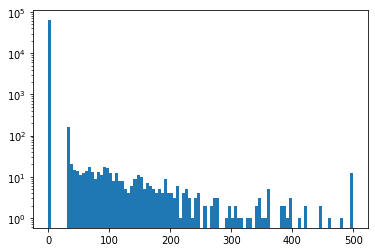

In [48]:
plt.hist(h_df.spend, bins=100, log=1)
plt.show()

recency Y corr:  -0.07476533979106369 -0.016348232261341435


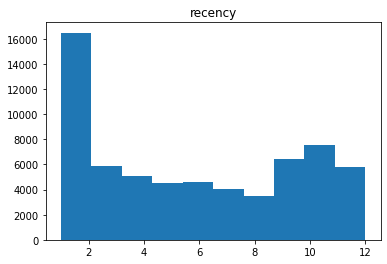

history Y corr:  0.0651533593508418 0.021729000144139907


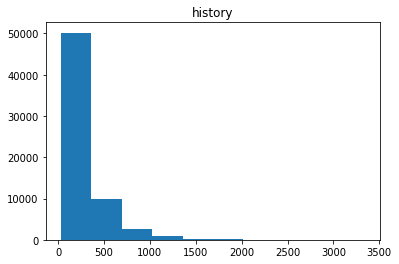

In [1352]:
for i in ['recency', 'history']:
    print(i, 'Y corr: ', np.corrcoef(h_df.visit, h_df[i])[0][1], np.corrcoef(h_df.spend, h_df[i])[0][1])
    plt.figure()
    plt.hist(h_df[i], bins=10)
    plt.title(i)
    plt.show()

In [22]:
h_df['segment'][h_df['segment']=='Womens E-Mail'] = 'w'
h_df['segment'][h_df['segment']=='Mens E-Mail'] = 'm'
h_df['segment'][h_df['segment']=='No E-Mail'] = 'ref'

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [23]:
h_df = h_df.sample(frac=1)
ind_train = int(len(h_df)/2.)

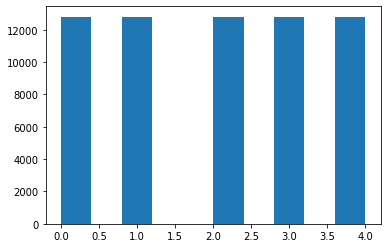

In [1364]:
plt.hist(pd.qcut(h_df['history'], 5, labels=False, duplicates='drop'))
plt.show()

In [622]:
params = {
    'policies_col': 'segment',
    # 'y_col': 'visit',
    # 'y_col': 'conversion',
    'y_col': 'spend',
    # 'partition_col': 'history',
    'partition_col': 'recency',
    'nb_groups_theo': 15,
    'n_bs': 100,
}

In [623]:
# h_df.history

In [624]:
h_df_grouped_train = df_prepro_h(h_df[:ind_train], params['policies_col'], params['y_col'], params['partition_col'], params['nb_groups_theo'], params['n_bs'])
_, bins_train = pd.qcut(h_df[:ind_train][params['partition_col']], params['nb_groups_theo'], retbins=True, labels=False, duplicates='drop')
h_df_grouped_test = df_prepro_h(h_df[ind_train:], params['policies_col'], params['y_col'], params['partition_col'], list(bins_train), params['n_bs'])

h_df_grouped_train[params['y_col']+'_bs_mean'] = h_df_grouped_train[params['y_col']+'_bs'].apply(lambda x:np.mean(x))
h_df_grouped_train[params['y_col']+'_bs_var'] = h_df_grouped_train[params['y_col']+'_bs'].apply(lambda x:np.var(x))

h_df_grouped_test[params['y_col']+'_bs_mean'] = h_df_grouped_test[params['y_col']+'_bs'].apply(lambda x:np.mean(x))
h_df_grouped_test[params['y_col']+'_bs_var'] = h_df_grouped_test[params['y_col']+'_bs'].apply(lambda x:np.var(x))

h_mu_0_train = np.array([h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs_mean'].values for i in h_df_grouped_train.groups.unique()])
h_Sigma_0_train = np.array([h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs_var'].values for i in h_df_grouped_train.groups.unique()])

h_mu_0_test = np.array([h_df_grouped_test[h_df_grouped_test.groups==i][params['y_col']+'_bs_mean'].values for i in h_df_grouped_test.groups.unique()])
h_Sigma_0_test = np.array([h_df_grouped_test[h_df_grouped_test.groups==i][params['y_col']+'_bs_var'].values for i in h_df_grouped_test.groups.unique()])

h_df_nbucket = len(h_df_grouped_test.groups.unique())
h_df_npol = len(h_df_grouped_train[params['policies_col']].unique())

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Index(['groups', 'segment', 'spend_bs', 'spend'], dtype='object')
Index(['groups', 'segment', 'spend_bs', 'spend'], dtype='object')


In [625]:
h_df_nbucket, h_df_npol

(11, 3)

In [626]:
# h_df_grouped_train

LinAlgError: singular matrix

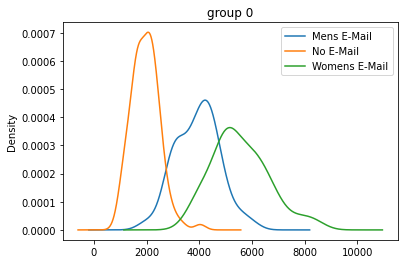

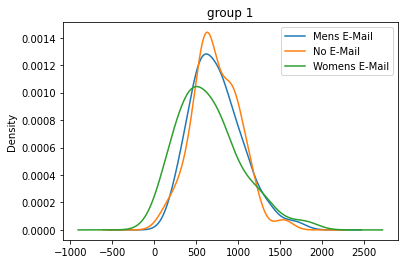

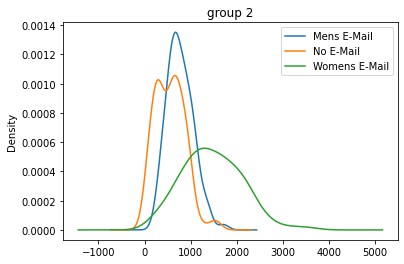

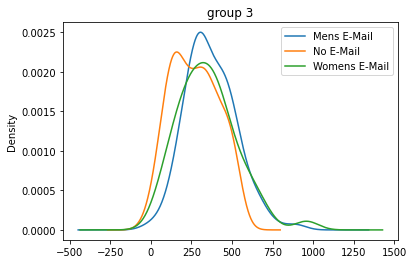

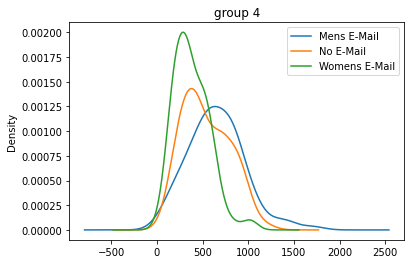

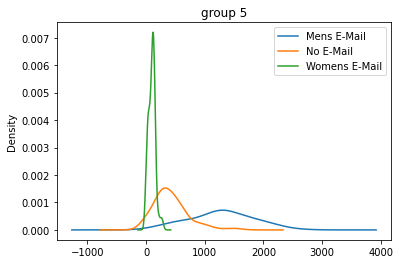

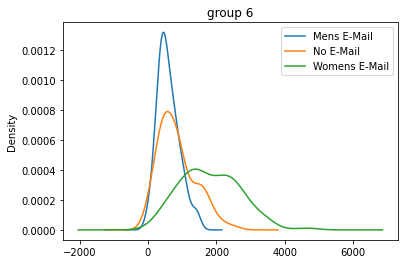

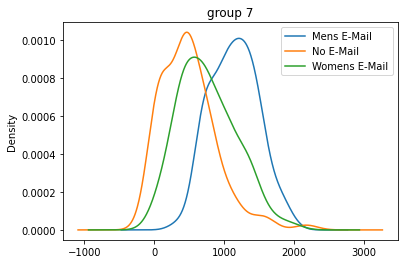

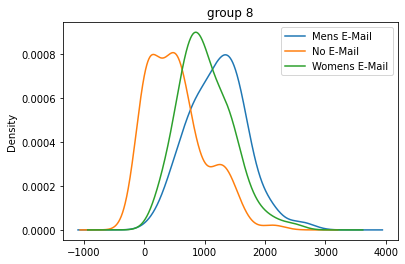

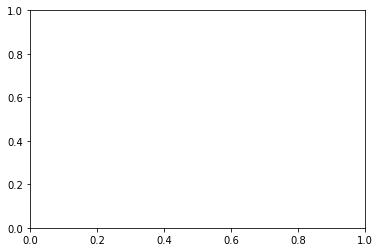

In [627]:
for i in h_df_grouped_train.groups.unique():
    pd.DataFrame(
        np.array(h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs'].tolist()).T, 
        columns=list(h_df_grouped_train[params['policies_col']].unique())
    ).plot(kind='density', title='group '+str(i))

In [628]:
h_mu_0_train

array([[3932.4985, 1958.9064, 5559.8557],
       [ 745.7327,  735.0373,  658.0425],
       [ 772.6853,  550.952 , 1466.5611],
       [ 370.253 ,  270.4397,  350.4848],
       [ 649.6163,  540.6638,  380.8531],
       [1278.2061,  421.2195,   98.9396],
       [ 594.9376,  842.4332, 1818.3693],
       [1144.4631,  497.2452,  762.1694],
       [1211.9612,  532.6056, 1012.5484],
       [   0.    ,  278.9678,  585.3318],
       [ 998.682 ,  124.8377,  116.4002]])

In [629]:
h_Sigma_0_train

array([[ 674350.33764675,  275038.24529904, 1157313.26434851],
       [  91565.18096571,   76333.25562171,  144772.63901875],
       [  76603.00192091,   99827.701542  ,  408083.85339379],
       [  23673.517113  ,   20458.49511691,   32990.77846696],
       [  93698.85681131,   64416.56859756,   36829.63519139],
       [ 294207.09853379,   86358.90988075,    3296.90906984],
       [  97926.68289624,  288057.98302576,  727746.42540651],
       [ 112522.27185139,  158093.39081496,  165431.47645964],
       [ 221794.40102256,  224009.90660664,  190681.00690744],
       [      0.        ,   53472.30450716,   95263.41621076],
       [ 342236.772896  ,   13404.38584771,    8983.16718396]])

In [630]:
h_df_ref_col = 0

h_total_y_ref = np.sum(np.array(h_mu_0_train)[:,h_df_ref_col])

h_df_r_y = 1. * h_total_y_ref

In [631]:
methods = ['greedy_soft', 'SPM']
h_df_allocs_dict = {}

### greedy allocation
h_df_allocs_dict['greedy'] = greedy_1d(h_mu_0_train)

### initial allocation to start SPM from 
h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket)
# h_df_psi_0 = h_df_allocs_dict['greedy']

h_df_allocs_dict['SPM'] = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_r_y, h_df_psi_0, n_steps=100000, eta = 0.1))

In [632]:
h_df_allocs_dict['greedy']

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [633]:
h_df_allocs_dict['SPM']

array([[0.        , 0.        , 1.        ],
       [0.6897303 , 0.31026977, 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ]], dtype=float32)

In [634]:
evaluate_1d_v2(h_df_allocs_dict['greedy'], h_mu_0_train, h_Sigma_0_train, h_df_r_y), evaluate_1d_v2(h_df_allocs_dict['greedy'], h_mu_0_test, h_Sigma_0_test, h_df_r_y)

(0.9856070528832299, 0.9622057423035211)

In [635]:
evaluate_1d_v2(h_df_allocs_dict['SPM'], h_mu_0_train, h_Sigma_0_train, h_df_r_y), evaluate_1d_v2(h_df_allocs_dict['SPM'], h_mu_0_test, h_Sigma_0_test, h_df_r_y)

(0.9855957732142752, 0.9197057662173667)

In [636]:
### for hard bruteforce
h_df_candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=h_df_npol)) if sum(comb) == 1]
h_df_all_hard_allocs = list(itertools.product(h_df_candidates, repeat=h_df_nbucket))

### greedy allocation
h_df_greedy_alloc = greedy_1d(h_mu_0_train)

In [637]:
### Define r_y (success region) with AB test interpretation
h_df_R_ys = h_total_y_ref * (1 + np.arange(0, 0.3, 0.01))

methods = ['greedy', 'SPM']
h_df_res_y_1d = {i:np.zeros_like(h_df_R_ys) for i in methods}

In [638]:
for i in tqdm(range(len(h_df_R_ys))):
    
    # h_df_hard_bf_alloc = hard_bruteforce_1d(y_bs, all_hard_allocs, Rs[i])
    # h_df_res_y_1d['hard_bf'][i] = evaluate_1d(y_bs, hard_bf_alloc, Rs[i])
    
    h_df_res_y_1d['greedy'][i] = evaluate_1d_v2(h_df_greedy_alloc, h_mu_0_train, h_Sigma_0_train, h_df_R_ys[i])
    
    ### initial allocation to start SPM from 
    h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    
    h_df_spm_alloc = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_R_ys[i], h_df_psi_0, n_steps=10000, eta = 0.01))
    h_df_res_y_1d['SPM'][i] = evaluate_1d_v2(h_df_spm_alloc, h_mu_0_train, h_Sigma_0_train, h_df_R_ys[i])

100%|██████████| 30/30 [00:02<00:00, 12.98it/s]


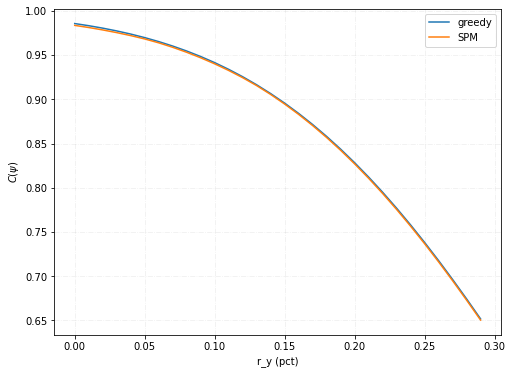

In [639]:
plt.figure(figsize=(8,6))

for m in h_df_res_y_1d.keys():
    plt.plot(
        (h_df_R_ys / h_total_y_ref) - 1,
        h_df_res_y_1d[m],
        label=m
    )
    
plt.xlabel('r_y (pct)')
plt.ylabel('$C(\psi)$')
plt.grid(alpha=0.2, ls="-.")
# plt.title('psi_0 = '+str(psi_0))
plt.legend()
plt.show()

In [614]:
for i in tqdm(range(len(h_df_R_ys))):
    
    # h_df_hard_bf_alloc = hard_bruteforce_1d(y_bs, all_hard_allocs, Rs[i])
    # h_df_res_y_1d['hard_bf'][i] = evaluate_1d(y_bs, hard_bf_alloc, Rs[i])
    
    h_df_res_y_1d['greedy'][i] = evaluate_1d_v2(h_df_greedy_alloc, h_mu_0_test, h_Sigma_0_test, h_df_R_ys[i])
    
    ### initial allocation to start SPM from 
    h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    
    h_df_spm_alloc = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_R_ys[i], h_df_psi_0, n_steps=10000, eta = 0.01))
    h_df_res_y_1d['SPM'][i] = evaluate_1d_v2(h_df_spm_alloc, h_mu_0_test, h_Sigma_0_test, h_df_R_ys[i])

100%|██████████| 30/30 [00:01<00:00, 17.79it/s]


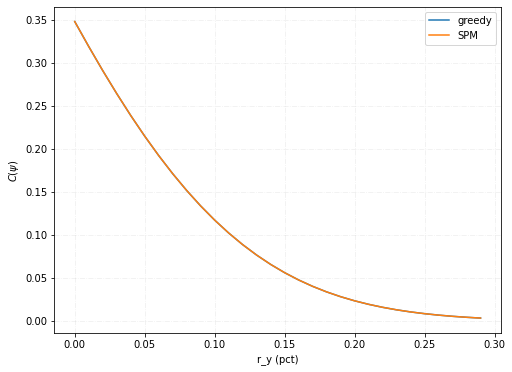

In [615]:
plt.figure(figsize=(8,6))

for m in h_df_res_y_1d.keys():
    plt.plot(
        (h_df_R_ys / h_total_y_ref) - 1,
        h_df_res_y_1d[m],
        label=m
    )
    
plt.xlabel('r_y (pct)')
plt.ylabel('$C(\psi)$')
plt.grid(alpha=0.2, ls="-.")
# plt.title('psi_0 = '+str(psi_0))
plt.legend()
plt.show()